# 한국 부동산 시장 분석 및 투자 전략 수립

## 과제 1: 서울 인기구 vs 비인기구 부동산 시장 비교 분석
가격 변동 패턴 비교분석, 지역별 시장 특성 및 투자 매력도 평가

- 인기구: 거래액/거래량 기준 상위 3개구, 비인기구: 거래액/거래량 기준 하위 3개구

- 지역별 시장 특성 시각화
  - 거래 밀도, 평균 거래가, 변동성 지표 등등

- 투자 매력도 -> 변동성, 수익률 
  - 변동성: 월 수익률의 표준편차로 확인
  - 추세지표: 월별 가격의 이동평균 및 이동표준편차

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')

plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

df_sales = pd.read_csv('./data/sales_clean.csv')
df_sales['계약일'] = pd.to_datetime(df_sales['계약일'], format='%Y%m%d')
df_sales['계약월'] = pd.to_datetime(df_sales['계약월'], format='%Y-%m-%d')

df_sales_copy = df_sales.copy()
# display(df_sales_copy.info())

In [8]:
# 인기구/비인기구 정의 - 최근 12개월 기준 누적 거래액 기준 상위 3개구 / 하위 3개구

latest_month = df_sales_copy['계약월'].max()
one_year_ago = latest_month - pd.DateOffset(months=12)

filtered_year_df = df_sales_copy[df_sales_copy['계약일'] > one_year_ago]

district_sales_stats = filtered_year_df.groupby('구').agg({
    '거래금액': ['count', 'sum']
}).round(0)

district_sales_stats.columns = ['거래건수', '총거래액']

popular = district_sales_stats.sort_values(by = ['총거래액', '거래건수'], ascending=[False, False]).head(3).index.tolist()
unpopular = district_sales_stats.sort_values(by = ['총거래액', '거래건수'], ascending=[True, False]).head(3).index.tolist()

print(f'인기구: {popular}\n비인기구: {unpopular}')

# 구분 컬럼 추가
df_sales_copy['구분'] = df_sales_copy['구'].apply(
    lambda x: '인기구' if x in popular else ('비인기구' if x in unpopular else '기타')
)

인기구: ['강남구', '서초구', '송파구']
비인기구: ['금천구', '강북구', '종로구']


In [9]:
# 인기/비인기구만 추출
sales_popular_mask = df_sales_copy['구'].isin(popular + unpopular)
df_popular = df_sales_copy[sales_popular_mask]
# display(df_popular)

## 1. 전체 평균 거래가, 평단가

df_popular_1year = df_popular[df_popular['계약일'] > one_year_ago]
avg_price_stats = df_popular_1year.groupby('구').agg({
    '거래금액': 'mean',
    '평단가': 'mean'
}).round(0).reset_index()
avg_price_stats.columns = ['구', '평균거래가', '평균평단가']
display(avg_price_stats)

## 2. 월별/연도별 통계
from da_utils.calc_monthly_annual import calc_monthly_annual
monthly_stats, annual_stats = calc_monthly_annual(df_popular, '구')
monthly_stats['구분'] = monthly_stats['구'].apply(
    lambda x: '인기구' if x in popular else ('비인기구' if x in unpopular else '기타')
)
# display(monthly_stats, annual_stats)

,구,평균거래가,평균평단가
0,강남구,2.358090e+09,86614216.0
1,강북구,5.436272e+08,25888258.0
2,금천구,5.416452e+08,25877232.0
3,서초구,2.368311e+09,85235480.0
4,송파구,1.566068e+09,63108726.0
5,종로구,1.071384e+09,44047412.0


In [10]:
## 3. 거래밀도 (월별 거래건수 / 인구수)

### 구별/월별 인구수 데이터
population_df = pd.read_csv('./data_raw/등록인구(월별).csv', header=[0, 1])
population_df = population_df.drop(columns=[population_df.columns[0]])
population_df.columns = ['_'.join(filter(None, map(str, col))).strip() for col in population_df.columns.values]

population_df_long = population_df.melt(id_vars=['동별(2)_동별(2)'], var_name='계약월_항목', value_name='값')
population_df_long[['계약월','항목']] = population_df_long['계약월_항목'].str.split('_', expand=True)
population_df_long['계약월'] = pd.to_datetime(population_df_long['계약월'].str.replace(" ", "").str.replace(".", "-"), format='%Y-%m')

### 피벗
df_population = population_df_long.pivot_table(
    index=['동별(2)_동별(2)', '계약월'],
    columns='항목',
    values='값'
).reset_index()
df_population.rename(columns={
    '동별(2)_동별(2)': '구',
    '세대 (세대)': '세대수',
    '합계 (명)': '총인구'
}, inplace=True)

### 거래밀도 계산(세대수, 총인구별)
population_popular_mask = df_population['구'].isin(popular + unpopular)
population_density = pd.merge(df_population[population_popular_mask], monthly_stats[['구','계약월','월별거래건수']], on=['구', '계약월'], how='left')
population_density['구분'] = population_density['구'].apply(lambda x: '인기구' if x in popular else '비인기구')
population_density['거래밀도_총인구'] = population_density['월별거래건수'] / population_density['총인구']
population_density['거래밀도_세대수'] = population_density['월별거래건수'] / population_density['세대수']
# display(population_density)

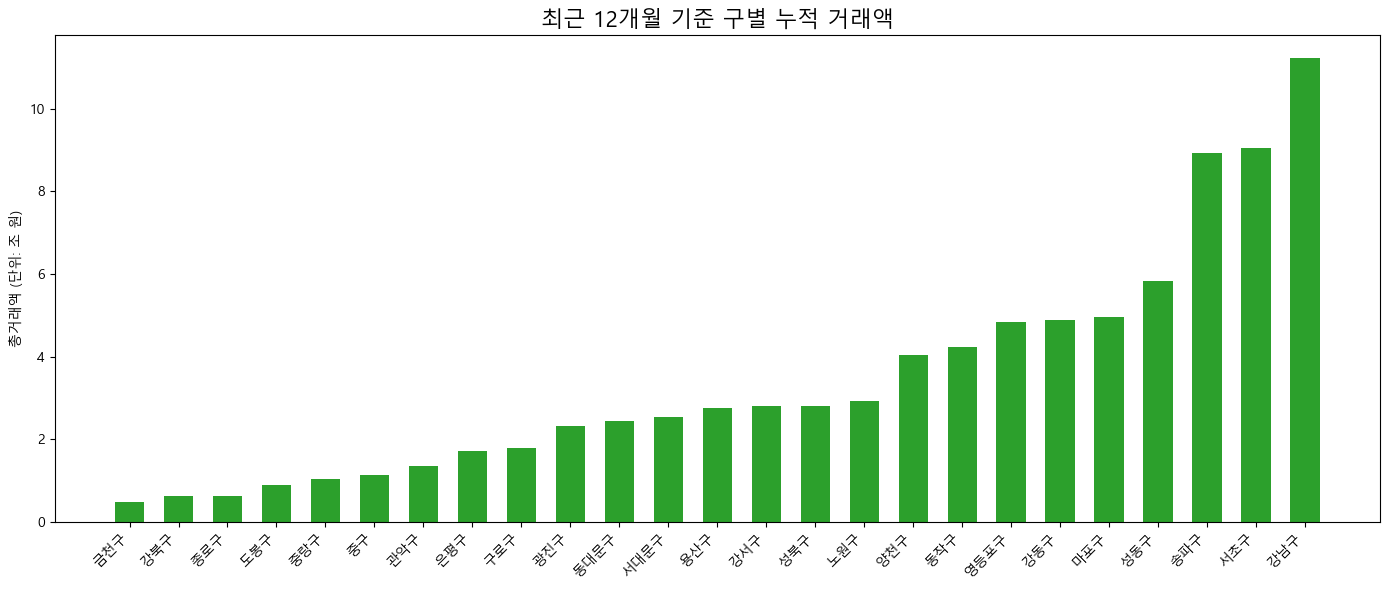

In [11]:
# 인기구/비인기구 구분 그래프
district_sales_stats_plot = district_sales_stats.copy().sort_values('총거래액')
district_sales_stats_plot['총거래액'] = district_sales_stats_plot['총거래액'] / 1e12
district_sales_stats_plot.columns = ['거래건수', '총거래액 (조원)']
district_sales_stats_plot = district_sales_stats_plot.round(3)
# display(district_sales_stats_plot)
district_sales_stats_plot.to_csv('./data/01_market_comparison/구별총거래액.csv')

## 시각화
x = np.arange(len(district_sales_stats_plot.index))

fig, ax = plt.subplots(figsize=(14,6))
ax.bar(x, district_sales_stats_plot['총거래액 (조원)'], 0.6, color='tab:green')
ax.set_title('최근 12개월 기준 구별 누적 거래액', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(district_sales_stats_plot.index, rotation=45, ha='right')
ax.set_ylabel('총거래액 (단위: 조 원)')
ax.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('fig/01_market_comparison/구별총거래액.png', dpi=300, bbox_inches='tight')
plt.show()

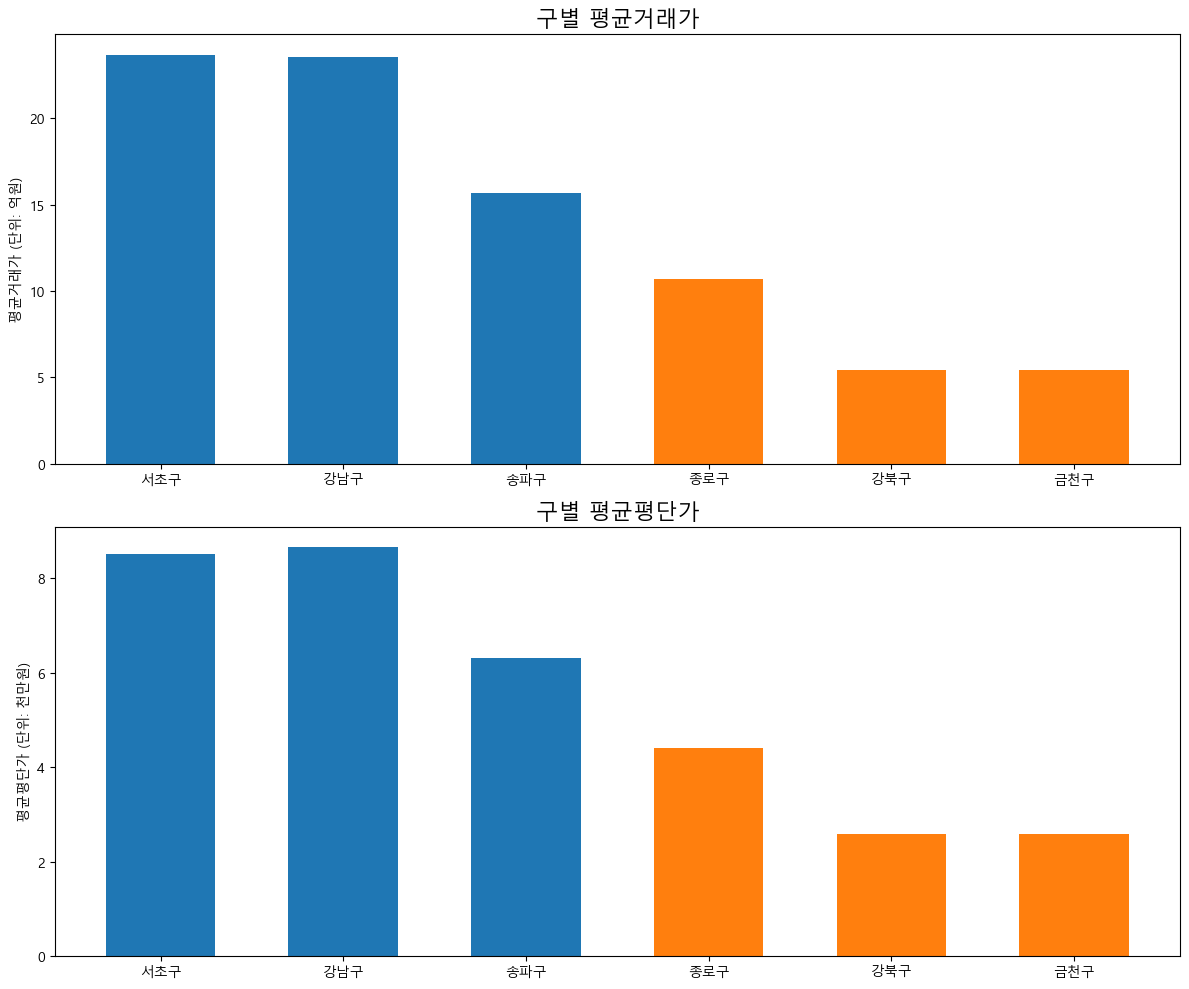

In [12]:
# 핵심 지표의 시각화

## 값 단위 조정
avg_price_stats_plot = avg_price_stats.sort_values('평균거래가', ascending=False).copy()
avg_price_stats_plot['평균거래가'] = avg_price_stats_plot['평균거래가'] / 1e8
avg_price_stats_plot['평균평단가'] = avg_price_stats_plot['평균평단가'] / 1e7
avg_price_stats_plot.columns = ['구', '평균거래가 (억원)', '평균평단가 (천만원)']
avg_price_stats_plot = avg_price_stats_plot.round(3).reset_index(drop=True)
# display(avg_price_stats_plot)
avg_price_stats_plot.to_csv('./data/01_market_comparison/구별연평균가격.csv')

## 시각화
colors = ['tab:blue' if g in popular else 'tab:orange' for g in avg_price_stats_plot['구']]
x = np.arange(len(avg_price_stats_plot['구']))

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(12,10))

### 평균거래가(억원) 바 차트
ax1.bar(x, avg_price_stats_plot['평균거래가 (억원)'], 0.6, color=colors)
ax1.set_title('구별 평균거래가', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(avg_price_stats_plot['구'])
ax1.set_ylabel('평균거래가 (단위: 억원)')
ax1.ticklabel_format(style='plain', axis='y')


### 평균평단가(천만원) 바 차트
ax2.bar(x, avg_price_stats_plot['평균평단가 (천만원)'], 0.6, color=colors)
ax2.set_title('구별 평균평단가', fontsize=16)
ax2.set_xticks(x)
ax2.set_xticklabels(avg_price_stats_plot['구'])
ax2.set_ylabel('평균평단가 (단위: 천만원)')
ax2.ticklabel_format(style='plain', axis='y')

plt.tight_layout()
plt.savefig('fig/01_market_comparison/구별평균거래가_구별평균평단가.png', dpi=300, bbox_inches='tight')
plt.show()

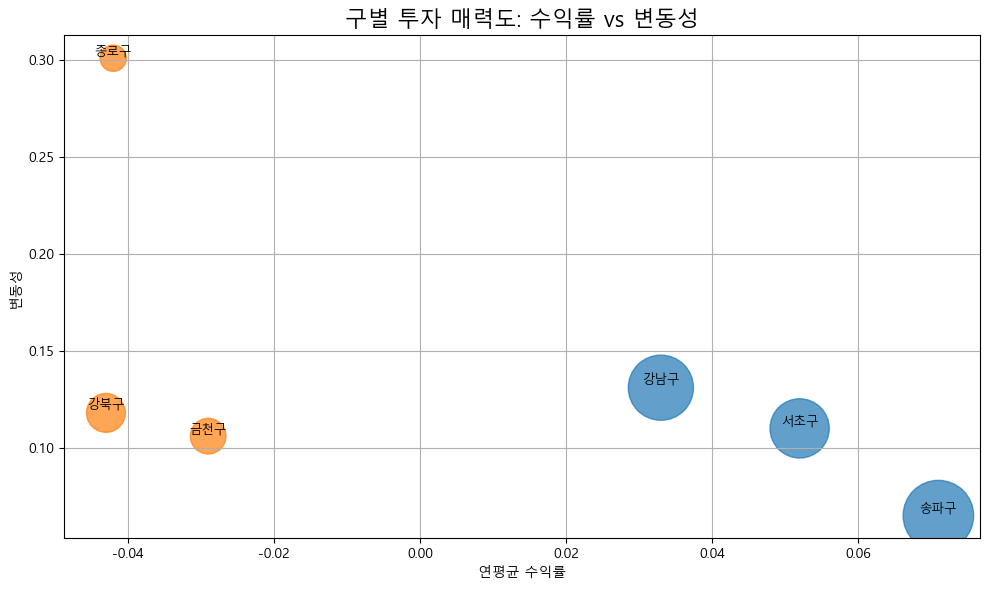

In [13]:
# 구별 투자 매력도

## 구별 연평균 수익률 계산
avg_return = annual_stats.groupby('구')['연간수익률'].mean().reset_index()
avg_annual_stats = annual_stats.groupby('구')['변동성'].mean().reset_index()
investment_df = avg_return.merge(avg_annual_stats, on='구')

avg_monthly_volume = monthly_stats.groupby('구')['월별거래건수'].mean().reset_index()
investment_df = investment_df.merge(avg_monthly_volume, on='구')
investment_df = investment_df.sort_values('연간수익률').round(3).reset_index(drop=True)
investment_df.columns = ['구', '연간수익률 (%)', '변동성', '월별거래건수 (건)']
# display(investment_df)
investment_df.to_csv('./data/01_market_comparison/구별투자매력도.csv')


## 시각화
### 수익률 vs 변동성 산점도 그래프(점 크기: 평균거래건수)
colors = [ 'tab:blue' if x in popular else 'tab:orange' for x in investment_df['구'] ]

plt.figure(figsize=(10,6))
plt.scatter(
    investment_df['연간수익률 (%)'],
    investment_df['변동성'],
    s=investment_df['월별거래건수 (건)'] * 10,
    c=colors,
    alpha=0.7
)

for i, row in investment_df.iterrows():
    plt.text(row['연간수익률 (%)'], row['변동성'], row['구'], fontsize=9, ha='center', va='bottom')

plt.title('구별 투자 매력도: 수익률 vs 변동성', fontsize=16)
plt.xlabel('연평균 수익률')
plt.ylabel('변동성')
plt.grid(True)

plt.tight_layout()
plt.savefig('fig/01_market_comparison/구별투자매력도.png', dpi=300, bbox_inches='tight')
plt.show()

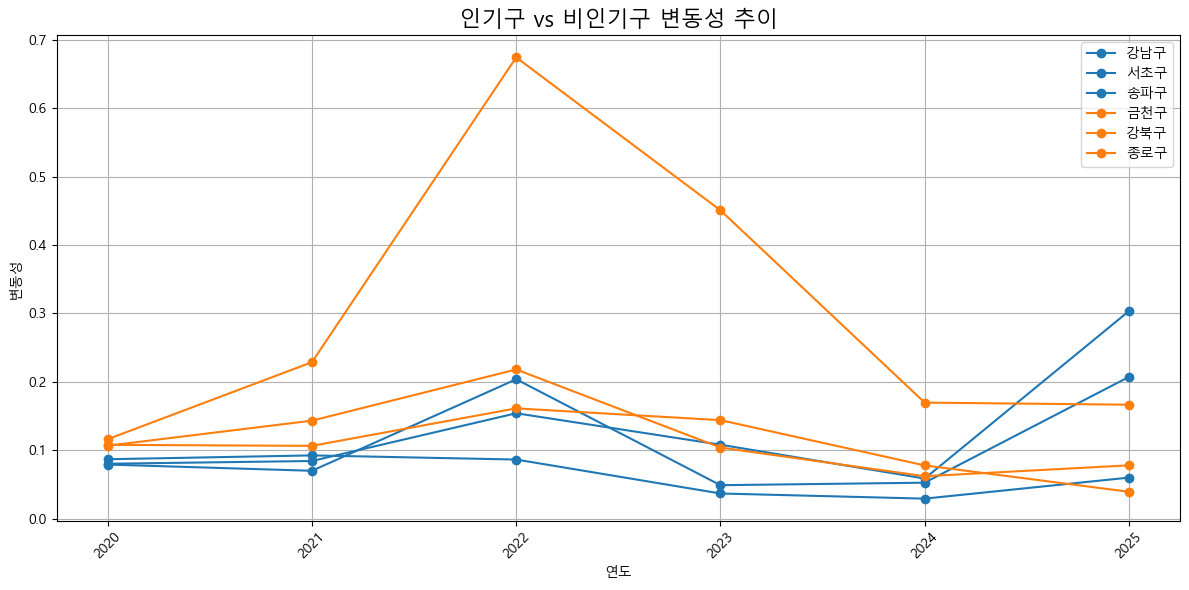

In [14]:
# 변동성 추이

## 시각화
plt.figure(figsize=(12,6))

### 인기구 라인그래프
for g in popular:
    plt.plot(annual_stats[annual_stats['구'] == g]['연도'],
             annual_stats[annual_stats['구'] == g]['변동성'],
             marker='o', label=g, color='tab:blue')

### 비인기구 라인그래프
for g in unpopular:
    plt.plot(annual_stats[annual_stats['구'] == g]['연도'],
             annual_stats[annual_stats['구'] == g]['변동성'],
             marker='o', label=g, color='tab:orange')

plt.title('인기구 vs 비인기구 변동성 추이', fontsize=16)
plt.xlabel('연도')
plt.xticks(annual_stats['연도'].unique(), rotation=45)
plt.ylabel('변동성')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('fig/01_market_comparison/변동성추이.png', dpi=300, bbox_inches='tight')
plt.show()

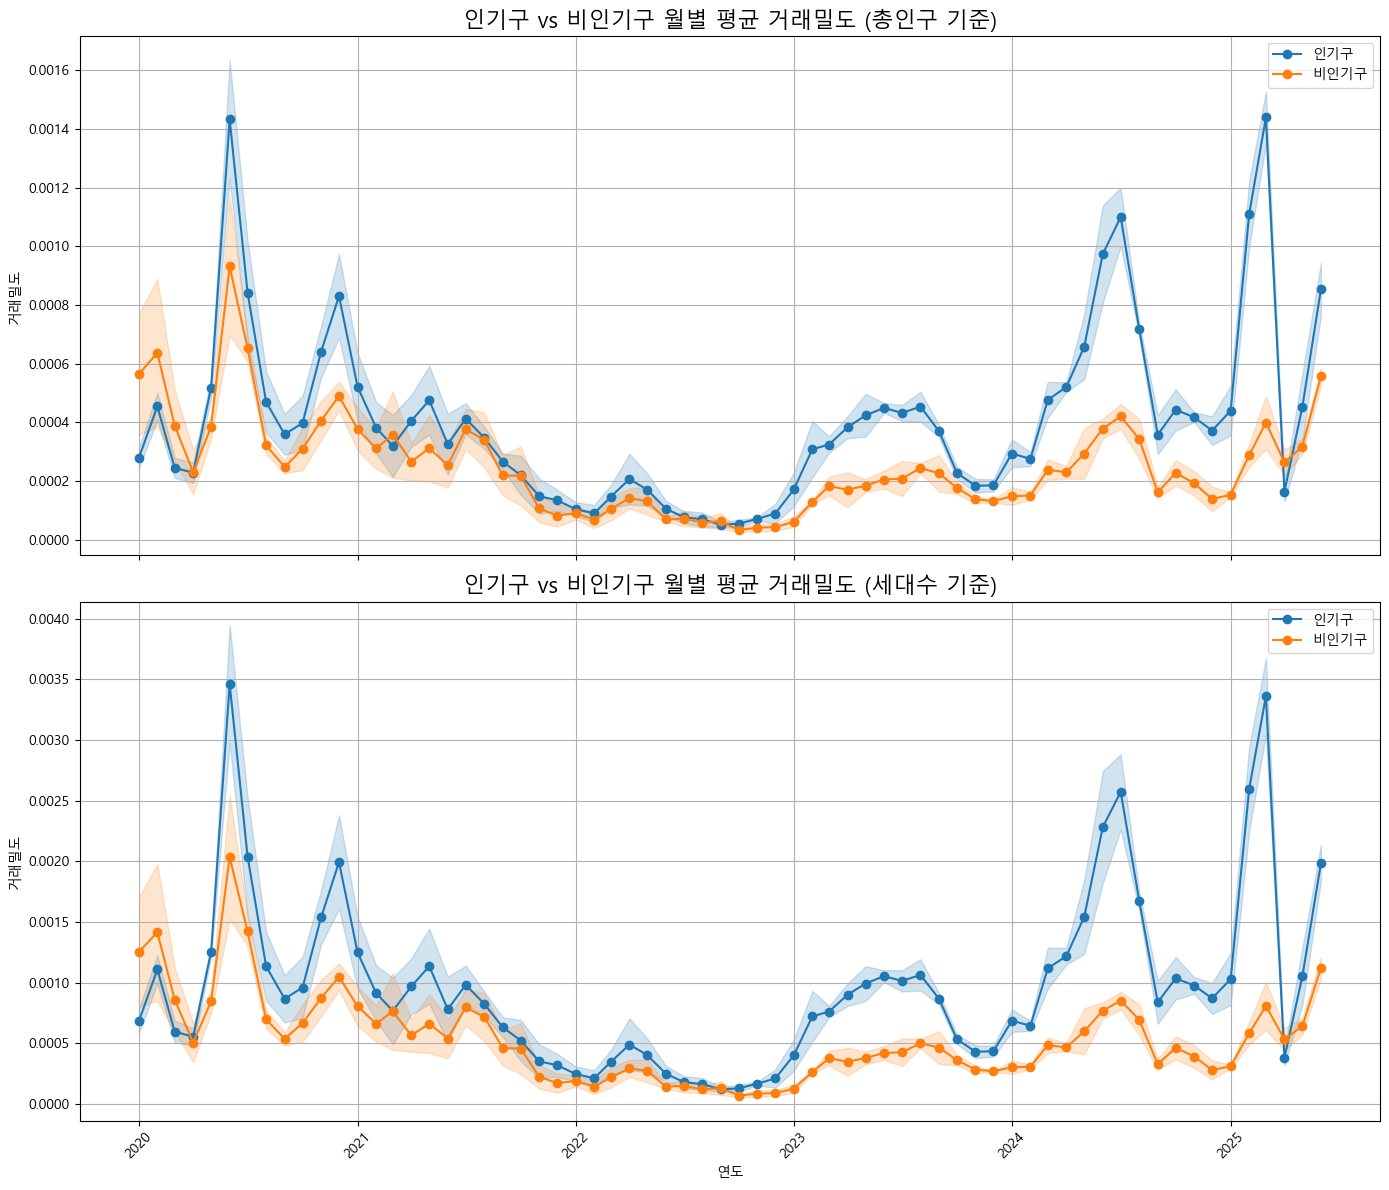

In [15]:
# 월별 거래밀도 비교
df_plot = population_density.copy()

df_summary = df_plot.groupby(['계약월','구분']).agg(
    거래밀도_총인구_mean=('거래밀도_총인구','mean'),
    거래밀도_총인구_std=('거래밀도_총인구','std'),
    거래밀도_세대수_mean=('거래밀도_세대수','mean'),
    거래밀도_세대수_std=('거래밀도_세대수','std')
).reset_index()

## 시각화
colors = {'인기구':'tab:blue', '비인기구':'tab:orange'}
fig, axes = plt.subplots(2, 1, figsize=(14,12), sharex=True)

### 총인구 기준
for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    axes[0].plot(subset['계약월'], subset['거래밀도_총인구_mean'], marker='o', label=group, color=colors[group])
    axes[0].fill_between(subset['계약월'],
                         subset['거래밀도_총인구_mean'] - subset['거래밀도_총인구_std'],
                         subset['거래밀도_총인구_mean'] + subset['거래밀도_총인구_std'],
                         color=colors[group], alpha=0.2)

axes[0].set_title('인기구 vs 비인기구 월별 평균 거래밀도 (총인구 기준)', fontsize=16)
axes[0].set_ylabel('거래밀도')
axes[0].grid(True)
axes[0].legend()

### 세대수 기준
for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    axes[1].plot(subset['계약월'], subset['거래밀도_세대수_mean'], marker='o', label=group, color=colors[group])
    axes[1].fill_between(subset['계약월'],
                         subset['거래밀도_세대수_mean'] - subset['거래밀도_세대수_std'],
                         subset['거래밀도_세대수_mean'] + subset['거래밀도_세대수_std'],
                         color=colors[group], alpha=0.2)

axes[1].set_title('인기구 vs 비인기구 월별 평균 거래밀도 (세대수 기준)', fontsize=16)
axes[1].set_xlabel('연도')
axes[1].set_ylabel('거래밀도')
axes[1].grid(True)
axes[1].legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('fig/01_market_comparison/월별평균거래밀도.png', dpi=300, bbox_inches='tight')
plt.show()

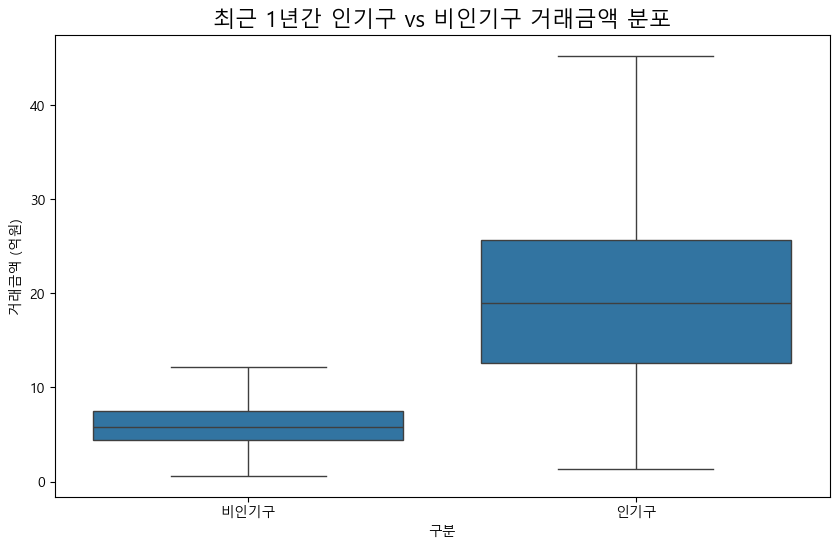

,거래금액 하위5% (억),거래금액 상위5% (억),거래금액 중앙값 (억),거래금액 IQR (억),거래금액 평균 (억),거래금액 표준편차 (억)
인기구,6.688,41.393,18.970,13.081,20.628,11.78
비인기구,2.178,15.919,5.767,3.153,6.624,3.97


In [16]:
# 거래금액 분포도

## 최근 12개월 기준 필터링
latest_month = df_sales_copy['계약월'].max()
one_year_ago = latest_month - pd.DateOffset(months=12)
df_recent = df_sales_copy[df_sales_copy['계약월'] > one_year_ago]
df_plot = df_recent[df_recent['구분'].isin(['인기구','비인기구'])]
df_plot['거래금액'] = df_plot['거래금액'] / 1e8


## 박스플롯: 거래금액
plt.figure(figsize=(10,6))
sns.boxplot(x='구분', y='거래금액', data=df_plot, showfliers=False)
plt.title('최근 1년간 인기구 vs 비인기구 거래금액 분포', fontsize=16)
plt.ylabel('거래금액 (억원)')
plt.savefig('fig/01_market_comparison/거래금액분포도.png', dpi=300, bbox_inches='tight')
plt.show()

# 요약 통계 추출

## 상하위 5%, 중앙값, IQR, 평균, 표준편차
summary_stats = {}
for group in ['인기구','비인기구']:
    subset = df_plot[df_plot['구분']==group]['거래금액']
    iqr = subset.quantile(0.75) - subset.quantile(0.25)
    summary_stats[group] = {
        '거래금액 하위5% (억)': subset.quantile(0.05),
        '거래금액 상위5% (억)': subset.quantile(0.95),
        '거래금액 중앙값 (억)': subset.median(),
        '거래금액 IQR (억)': iqr,
        '거래금액 평균 (억)': subset.mean(),
        '거래금액 표준편차 (억)': subset.std()
    }

summary_stats_df = pd.DataFrame(summary_stats).T
summary_stats_df = summary_stats_df.round(3)
display(summary_stats_df)
summary_stats_df.to_csv('./data/01_market_comparison/거래금액통계.csv')

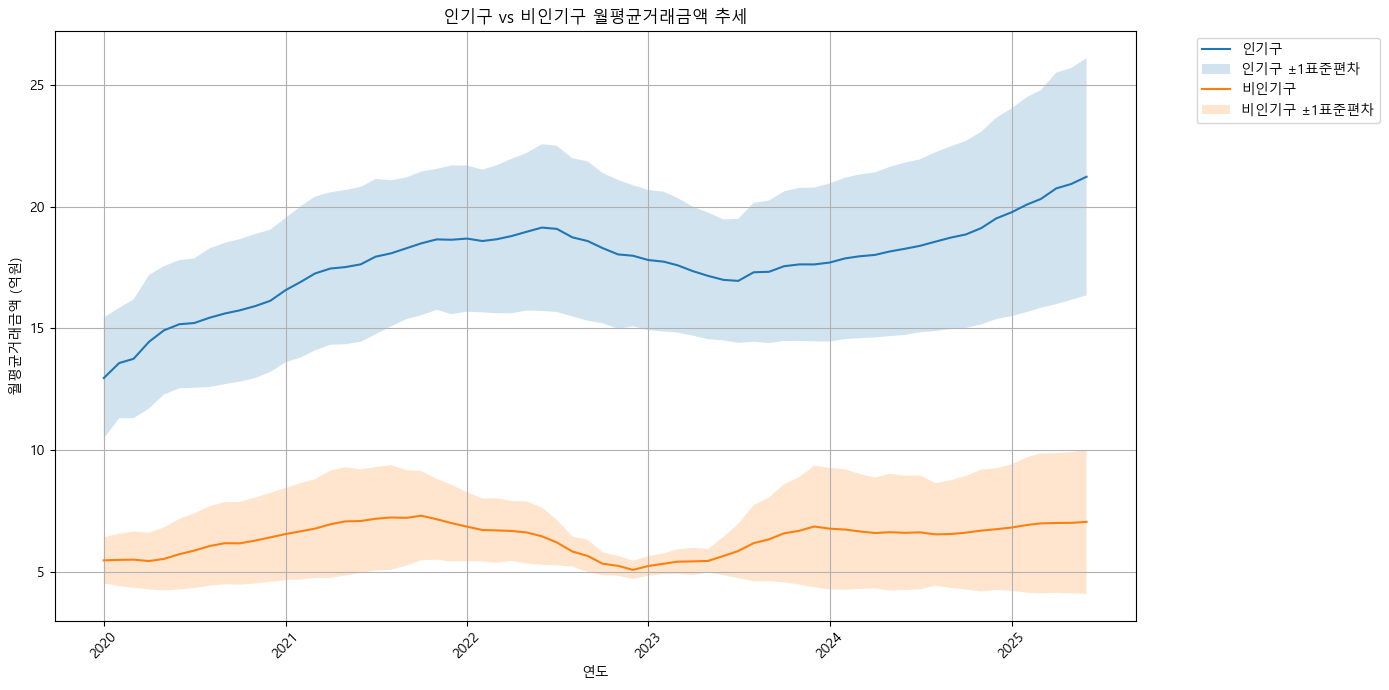

In [17]:
# 월평균거래금액 추세

## 인기구/비인기구 데이터 선택
df_plot = monthly_stats[monthly_stats['구'].isin(popular + unpopular)].copy()
df_plot['구분'] = df_plot['구'].apply(lambda x: '인기구' if x in popular else '비인기구')

## 시각화
### 구분별 월평균과 표준편차 계산
df_summary = df_plot.groupby(['계약월','구분'])['이동평균'].agg(['mean','std']).reset_index()

plt.figure(figsize=(14,7))

for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    plt.plot(subset['계약월'], subset['mean']/1e8, label=f'{group}')
    plt.fill_between(subset['계약월'],
                     (subset['mean'] - subset['std'])/1e8,
                     (subset['mean'] + subset['std'])/1e8,
                      alpha=0.2, label=f'{group} ±1표준편차')

plt.title('인기구 vs 비인기구 월평균거래금액 추세')
plt.xlabel('연도')
plt.xticks(rotation=45)
plt.ylabel('월평균거래금액 (억원)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

plt.tight_layout()
plt.savefig('fig/01_market_comparison/월평균거래금액추세.png', dpi=300, bbox_inches='tight')
plt.show()

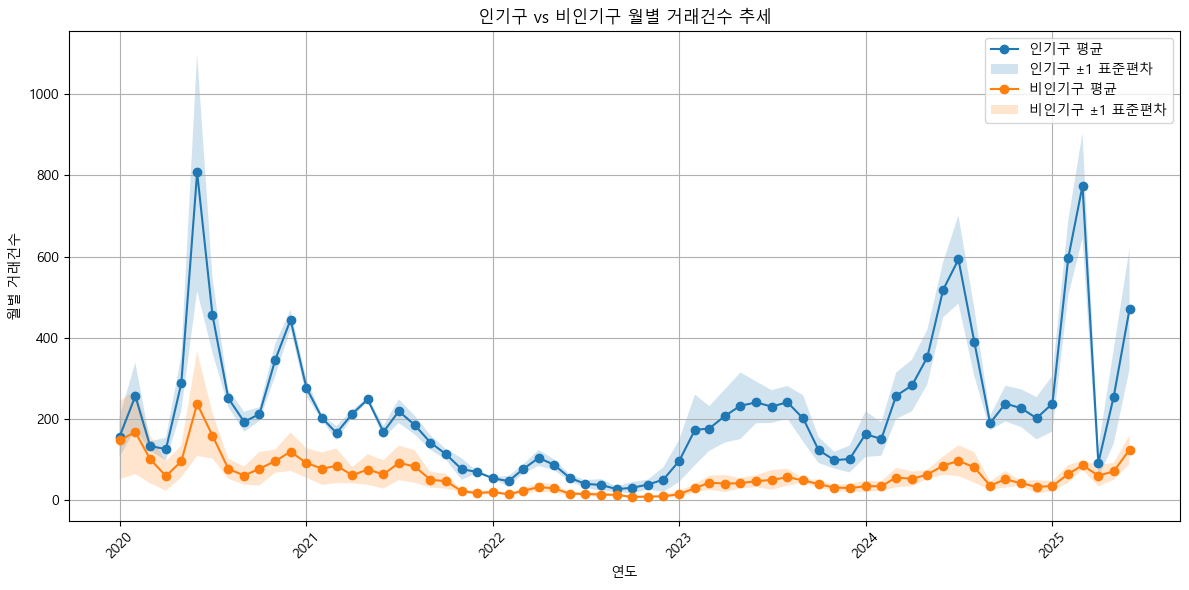

In [18]:
# 월별거래건수 추세

## 구분별 평균과 표준편차 계산
df_plot = monthly_stats[monthly_stats['구분'].isin(['인기구','비인기구'])]
df_summary = df_plot.groupby(['계약월','구분'])['월별거래건수'].agg(['mean','std']).reset_index()

## 시각화
plt.figure(figsize=(12,6))

for group in ['인기구','비인기구']:
    subset = df_summary[df_summary['구분']==group]
    plt.plot(subset['계약월'], subset['mean'], marker='o', label=f'{group} 평균')
    plt.fill_between(subset['계약월'],
                     subset['mean'] - subset['std'],
                     subset['mean'] + subset['std'],
                     alpha=0.2, label=f'{group} ±1 표준편차')

plt.title('인기구 vs 비인기구 월별 거래건수 추세')
plt.xlabel('연도')
plt.xticks(rotation=45)
plt.ylabel('월별 거래건수')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('fig/01_market_comparison/월별거래건수추세.png', dpi=300, bbox_inches='tight')
plt.show()

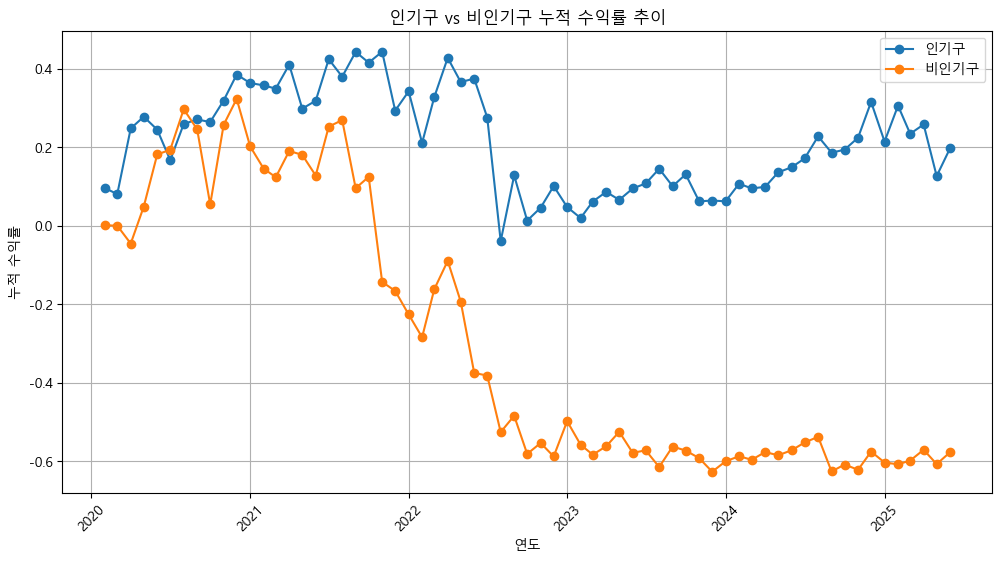

In [19]:
# 누적 수익률 추이

## 누적 수익률 계산
df_plot = monthly_stats[monthly_stats['구분'].isin(['인기구','비인기구'])]
df_plot = df_plot.sort_values(['구','계약월'])
df_plot['누적수익률'] = df_plot.groupby('구')['월별수익률'].transform(lambda x: (1 + x).cumprod() - 1)

## 구별 누적 수익률 평균 계산
df_avg = df_plot.groupby(['계약월','구분'])['누적수익률'].mean().reset_index()

## 시각화
plt.figure(figsize=(12,6))
for group in ['인기구','비인기구']:
    subset = df_avg[df_avg['구분']==group]
    plt.plot(subset['계약월'], subset['누적수익률'], marker='o', label=group)

plt.title('인기구 vs 비인기구 누적 수익률 추이')
plt.xlabel('연도')
plt.xticks(rotation=45)
plt.ylabel('누적 수익률')
plt.grid(True)
plt.legend()
plt.savefig('fig/01_market_comparison/누적수익률추이.png', dpi=300, bbox_inches='tight')
plt.show()